# Assigment 6
# Anup Anand Deshmukh
# 20837751


## Upload your code (.ipynb) on Learn dropbox and submit pdfs of the code and the mathematical questions to Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Rank-Sparsity 

## Question 1

Implement ADMM for the problem of separating a background image from foreground interference. Download the datasets at: http://www.svcl.ucsd.edu/projects/background_subtraction/JPEGS.tar.gz 

You will have to solve this problem:

$$
\begin{align*}
\mbox{minimize} & \ \|L\|_* + \gamma \|M\|_1 \\
\mbox{subj. to:} & \ L+M=A
\end{align*}
$$

where $\gamma>0$ is a parameter that you will have to tune. 

Use only the first dataset, birds, which contains 71 jpeg images each with 37752 gray-scale pixels. Form a matrix A of size 37752 x 71 with these images. 

When you are done, print the background image (that is, columns of the component L) for frames 1, 11, ..., 71. 

Note that this algorithm requires SVD. Computing the SVD in the usual way is very expensive for this dataset because the U matrix in SVD has size 37752 × 37752. You will have to utilize the "economy" SVD in https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.svd.html
or 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
by setting the option full_matrices = False.

Marks: 33.

In [2]:
import cv2
import glob
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import sys
from scipy import linalg
import scipy

import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

X_data = []
A = []
count = 0
files = sorted(glob.glob("/home/aa2deshm/Desktop/Waterloo/Fall 2019/Optimization_for_DS/A6/birds/*.jpg"), key=numericalSort)
for image in files:
    #print(image)
    read_im = np.array(cv2.imread(image))
    height,width = read_im.shape[0],read_im.shape[1]

    read_im = read_im.transpose(2,0,1).reshape(3,-1)
    read_im = read_im[0][:]
    
    A.append(read_im)
    if count < 70:
        X_data.append(read_im)
        count = count + 1
    else:
        print(count)
        print(image)
        Y_target = read_im
    
A = np.array(A).T
print('A shape:', np.array(A).shape)

X_data = np.array(X_data).T
print('X_data shape:', np.array(X_data).shape)

Y_target = np.array(Y_target).T
print('Y_target shape:', np.array(Y_target).shape)

70
/home/aa2deshm/Desktop/Waterloo/Fall 2019/Optimization_for_DS/A6/birds/frame_71.jpg
A shape: (37752, 71)
X_data shape: (37752, 70)
Y_target shape: (37752,)


In [3]:
def prox_nuclear_l(x, p):
    u, s, v = linalg.svd(x,full_matrices=False)
    condn = 1/p
    term = np.where(s >= condn, s - condn, 0)
    size = len(term)
    term = scipy.linalg.diagsvd(term,size,size)
    prox = (u.dot(term)).dot(v)
    return prox

def prox_l1_m(u, p, gamma):
    condn = gamma/p
    term = np.where(u >= condn, u - condn, u)
    term = np.where(np.absolute(u) <= condn, 0, term)
    prox = np.where(u <= -condn, u + condn, term)
    return prox

def ADMM_ranksparsity(A, p, m, y, max_iter, gamma, eps):
    iteration = 0
    while iteration < max_iter:
        send_l = A - m - y/p
        l = prox_nuclear_l(send_l, p)
        
        send_m = A - l - y/p
        m = prox_l1_m(send_m, p, gamma)
        
        y = y + p*(l + m - A)
        
        termination_condn = norm(l + m - A, 2)
        if termination_condn < eps: 
            break
        iteration = iteration + 1
    return l, m

In [21]:
max_iter = 50
p = 1
gamma = 0.0001
eps = 1e-9

m = np.zeros(A.shape)
y = np.zeros(A.shape)    
l_opt, m_opt = ADMM_ranksparsity(A, p, m, y, max_iter, gamma, eps)

Picture number:  1


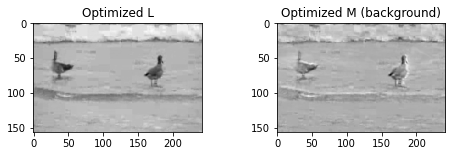

Picture number:  11


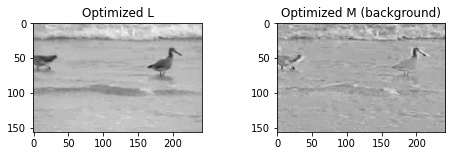

Picture number:  21


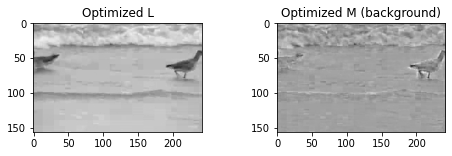

Picture number:  31


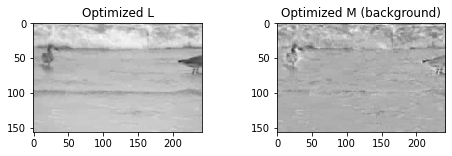

Picture number:  41


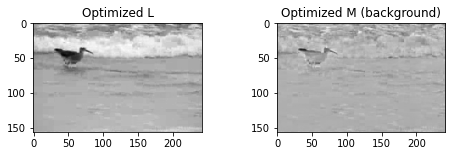

Picture number:  51


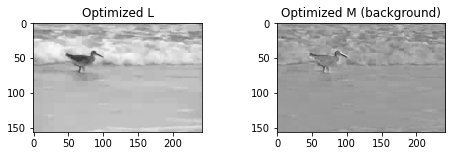

Picture number:  61


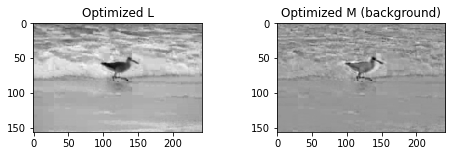

Picture number:  71


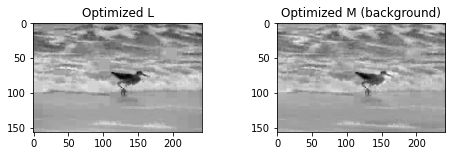

In [24]:
def show_images(l, m, num, height, width):
    plt.figure(figsize= (8,2))
    plt.subplot(1,2,1)
    im_vec1 = l_opt[:, num]
    image1 = im_vec1.reshape((height, width))
    plt.imshow(image1, cmap = 'gray')
    plt.title('Optimized L')
    
    plt.subplot(1,2,2)
    im_vec2 = m_opt[:, num]
    image2 = im_vec2.reshape((height, width))
    plt.imshow(image2, cmap = 'gray')
    plt.title('Optimized M (background)')
    
    plt.show()
    
for i in range(8):
    print("Picture number: ", i*10+1)
    show_images(l_opt, m_opt, i*10, height, width)

## Robust Linear Regression

## Question 2

Implement AM-RR (alternating minimization for robust regresion) on the same dataset as Q1. Form a matrix X whose columns are the first 70 bird images. Form a vector y that is the 71st image. Then try to fit $$y\approx Xw $$ using the Robust Linear Regression problem. 

Illustrate the following two plots. The first plot should show the image that was not covered by set S (S is an output of AM-RR). In other words, y(S^c), where S^c is the complement of S with respect to the set of all pixels. Pixels in S should be set to white (255, when the grey scale image is from 0 to 255) in this image. 

The second plot should show the image indexed by S, in other words, X(S,:)w. Fill in the entries not indexed by S 
to white. 

Marks: 33.

In [9]:
def init_vars(x, y, k):
    w = np.zeros(x.shape[1])
    s = np.array(np.arange(0,x.shape[0]-k))
    return w,s    
    
def alt_min_rr(x, y, w, s, max_iter, eps):
    iterations = 0
    while iterations < max_iter:
        x_set = x[s]
        y_set = y[s]
        step = norm(x,2)**2
        
        update = np.sum(np.multiply(x_set.dot(w) - y_set, x_set.T), axis = 1)
        
        w = w - 1./(step) *update
        
        termto_sort = np.square(y - x.dot(w))
        s = np.argsort(termto_sort,axis  =0)[:s.shape[0]]
        
        norm_termination = norm(y - x.dot(w),2)
        if norm_termination < eps:
            break
        
        iterations = iterations + 1
    return w, s

In [10]:
k = 3000
max_iter = 500
eps = 1e-4

w_init, s_init = init_vars(X_data, Y_target, k)
w_opt, s_opt = alt_min_rr(X_data, Y_target, w_init, s_init, max_iter, eps)

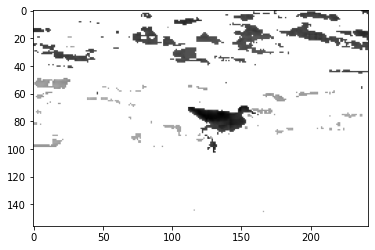

In [69]:
result = Y_target
result[s_opt] = 255
plt.imshow(result.reshape((height,width)), cmap = 'gray')

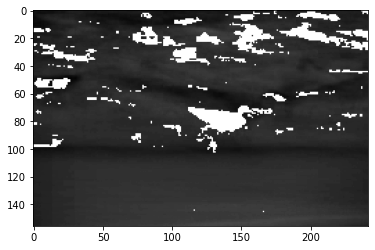

In [70]:
y_estimate = X_data[s_opt].dot(w_opt)
result = np.full(Y_target.shape,255)
result[s_opt] = y_estimate
plt.imshow(result.reshape((height,width)), cmap = 'gray')

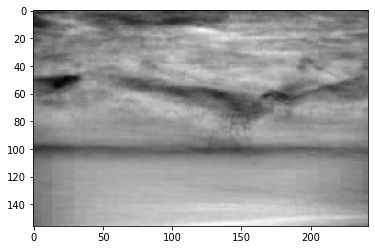

In [71]:
plt.imshow(X_data.dot(w_opt).reshape((height,width)), cmap = 'gray')

## Nonnegative matrix factorization

Consider the nonnegative matrix factorization problem. For this problem, we showed that the modified multiplicative updates algorithm satisfies the nonnegativity constraints at each iteration. Consider now the nonnegative sparse coding problem:
$$
\begin{align*}
\mbox{minimize}_{W,H} &  \ F(W,H):= \frac{1}{2}\| WH-X\|_F^2 + \lambda \|H\|_1\\
\mbox{subj. to} & \ W_{ij}\ge 0 \ \forall i,j \\
                &  \ H_{ij}\ge 0 \ \forall i,j,
\end{align*}
$$
where 
$$
\|H\|_1 = \sum_{i,j} |H_{ij}|.
$$
and $\lambda \ge 0$ is a parameter that controls the effect of the l1-norm. This problem is called sparse coding because the l1-norm forces a lot of weights in matrix $H$ to become zero.

## Question 3

Show that the modified multiplicative updates algorithm for the above nonnegative sparse coding problem also satisfies the nonnegative constraints at each iteration. 

Marks: 5

(4096, 400)
Dataset consists of 4096 faces


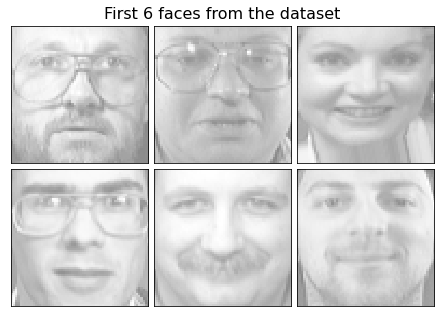

In [103]:
# This piece of code is for loading data and visualizing 
# the first 6 images in the dataset.

# Useful packages for loading the data and plotting
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

n_row, n_col = 2, 3
image_shape = (64, 64)
rng = RandomState(0)

# Useful function for plotting
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)

# Store the vectorized images. Each image has dimensions 64 x 64.
faces = dataset.data
faces = faces.T

n_samples = faces.shape[0]

print(faces.shape)
print("Dataset consists of %d faces" % n_samples)
    
plot_gallery("First 6 faces from the dataset", faces.T[:6])    

In [104]:
def obj_nnmf(w, h, x):
    return norm((w.dot(h) - x))**2 

def grad_h(w, h, x, lambda_):
    return w.T.dot(w.dot(h) - x)

def grad_w(w, h, x):
    return (w.dot(h) - x).dot(h.T)


def find_h_bar(wi, hi, xi, sigma, lambda_): 
    hn = hi.copy()
    
    grad = grad_h(wi, hn, xi, lambda_)
    ind = np.where(grad < 0.)
    
    h_val = hn[ind]
    check_arr = np.full(h_val.shape[0], sigma)
    
    change = np.maximum(h_val, check_arr)
    hn[ind] = change
    
    return hn
    
def find_w_bar(wi, hi, xi, sigma): 
    wn = wi.copy()
    
    grad = grad_w(wn, hi, xi)
    ind = np.where(grad < 0.)
    
    w_val = wn[ind]
    check_arr = np.full(w_val.shape[0], sigma)
    
    change = np.maximum(w_val, check_arr)
    wn[ind] = change
    
    return wn

def prox_h(h_pass, condn):
    term = np.where(h_pass >= condn, h_pass - condn, 0)
    term = np.where(h_pass <= -condn, h_pass + condn, term)
    return term


In [126]:
def mult_algo(w, h, x, sigma, delta, lambda_, iteration):
    max_iter = 1
    while max_iter < iteration:
        h_bar = find_h_bar(w, h, x, sigma, lambda_)
        w_bar = find_w_bar(w, h, x, sigma)
        
        numer_h = h_bar
        den_h = (w.T.dot(w)).dot(h_bar) + np.full(numer_h.shape, delta)
        h_pass = h - np.divide(numer_h, den_h)* grad_h(w, h, x, lambda_)
        h_new = prox_h(h_pass, np.divide(numer_h, den_h)*lambda_)
        
        numer_w = w_bar
        den_w = w_bar.dot((h.dot(h.T))) + np.full(numer_w.shape, delta)
        w_new = w - np.divide(numer_w, den_w)* grad_w(w, h_new, x)
        
        w_cs =  w_new.sum(axis = 0)
        s = (1.0/w_cs)
        s_mat = np.diag(s)
        s_mat_inv = np.diag(1/s) 
        
        h = s_mat_inv.dot(h_new)
        w = w_new.dot(s_mat)
    
        f_x = obj_nnmf(w, h, x)
        #print(f_x)
        max_iter = max_iter + 1    
        
    return w, h

## Question 4

Use the face dataset, see Assigment 5. Set parameter $r=6$ in the nonnegative factorization problem. Plot $\frac{1}{2}\| WH-X\|_F^2$ as $\lambda$ increases.

Marks: 12

In [122]:
iterations = 500
m = faces.shape[0]
n = faces.shape[1]
r = 6

w_init = np.random.random((m, r))
h_init = np.random.random((r, n))
x_train = faces
sigma = 0.5
delta = 0.5

obj_list = []
#lambda_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 1.2]
lambda_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
for lamb in np.linspace(0.01, 0.12, 12):
    print(lamb)
    w_opt, h_opt = mult_algo(w_init, h_init, x_train, sigma, delta, lamb, iterations)
    
    obj_opt = obj_nnmf(w_opt, h_opt, x_train)
    obj_list.append(obj_opt)

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12


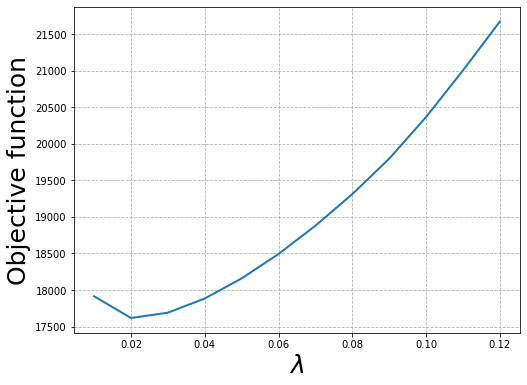

In [124]:
fig = plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0.01, 0.12, 12), obj_list,linewidth=2.0)
plt.xlabel("$\lambda$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 5

Choose a $\lambda$ and extract the features matrix $W$ by solving the nonnegative matrix factorization problem. Report the 6 features of the faces dataset, i.e., the 6 columns of matrix $W$. You can report the features by visualizing them in a similar way to the above example.

Marks: 12

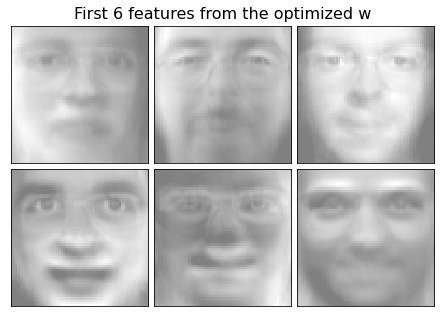

In [125]:
iterations = 500
m = faces.shape[0]
n = faces.shape[1]
r = 6

w_init = np.random.random((m, r))
h_init = np.random.random((r, n))
x_train = faces
sigma = 0.5
delta = 0.5
lamb = 0.02

w_opt_best, h_opt_best = mult_algo(w_init, h_init, x_train, sigma, delta, lamb, iterations)
plot_gallery("First 6 features from the optimized w", w_opt_best.T[:6])  

## Question 6


For your chosen $\lambda$, which are the most important features of the first 6 faces? Provide the code on how to obtain the most important features.

Marks: 5

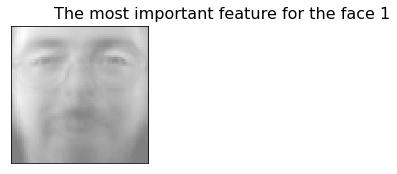

In [135]:
ind_sorted = np.argsort(h_opt_best[:, 0], axis = 0)[::-1]
face1 = w_opt_best.T[ind_sorted[:1]]
plot_gallery("The most important feature for the face 1", face1)

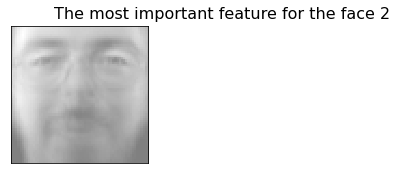

In [136]:
ind_sorted = np.argsort(h_opt_best[:, 1], axis = 0)[::-1]
face2 = w_opt_best.T[ind_sorted[:1]]
plot_gallery("The most important feature for the face 2", face2)

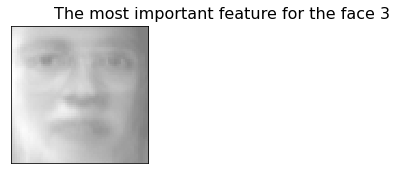

In [131]:
ind_sorted = np.argsort(h_opt_best[:, 2], axis = 0)[::-1]
face3 = w_opt_best.T[ind_sorted[:1]]
plot_gallery("The most important feature for the face 3", face3)

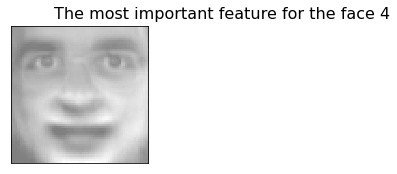

In [132]:
ind_sorted = np.argsort(h_opt_best[:, 3], axis = 0)[::-1]
face4 = w_opt_best.T[ind_sorted[:1]]
plot_gallery("The most important feature for the face 4", face4)

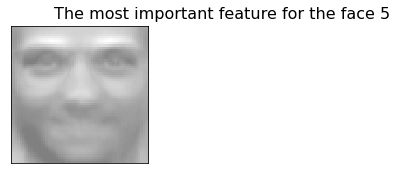

In [133]:
ind_sorted = np.argsort(h_opt_best[:, 4], axis = 0)[::-1]
face5 = w_opt_best.T[ind_sorted[:1]]
plot_gallery("The most important feature for the face 5", face5)

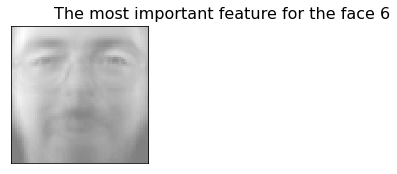

In [134]:
ind_sorted = np.argsort(h_opt_best[:, 5], axis = 0)[::-1]
face6 = w_opt_best.T[ind_sorted[:1]]
plot_gallery("The most important feature for the face 6", face6)